# **N02. Star detection**

Notebook focused on star detection in a Metis FITS image.

**Load libraries**


In [11]:
import libraries.starfunctions as sf
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import math
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
import numpy as np
from libraries.starcatalogs import StarCatalog
import libraries.utilities as ut

# Plotting configuration.
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["mathtext.fontset"] = "cm"  

## 1. Introduction

Once all the dataset is downloaded, the next step is to perform star detection. For the first phase, just visible light range images will be used. Then, an algorithm will be used for retrieve the stars location given.

### 1.1 Pipeline for star detection
As the main object is to detect objects in the images, first we need to extract all the objects that are stars. In order to do this, an algorithm was develop by **Paolo Chioetto**, and the repository can be found in the following link:

    https://github.com/chioettop/metis_star_utils

**Metis_star_utils**

Simulates Metis's Field-of-view using the *SO SPICE KERNEL*. Then it takes as input three parameters:
- **Timestamp**: date and time from where it is retrieved the real-time coordinates of metis.
- **Bandwidth**: bandwith used for detecting stars (Visible-light or UltraViolet)
- **StarMagnitude**: maximum star apparent magnitude able to detect.
- Another important parameters are used such as: sun radius, id (solar orbiter), metis fov.

With this information, timestamp is converted into **ephimeris time** and these angles from the metis are retrieved:
1. Right Ascencion (RA): Angular distance eastward along the celestial equator (longitude).
2. Declination (DEC): Angular distance from north to south (latitude).
3. Roll (ROLL) : Rotation of the instrument along the principal axis (boresight).

Once the angles are extracted, using the SIMBAD (Set of Identifications, Measurements, and Bibliography for Astronomical Dataset) Catalogue, it is queried in order to search for stars up to the desired StarMagnitude. Stars located in the inner metis FOV are discarded as well as stars in the outer FOV. Later an image will be displayed for better understanding.

Finally, it returns WCS (world coordinate system) from the previously computed angles and convert stars position into images pixels.

### 1.2 Implemented algorithm for star detection
The mentioned pipeline is implemented in the following function:

In [12]:
def stars_detector(kernel, path, time, mag, UV=False):
    """
    Retrieve a dataframe with stars on a given time coordinate according to Metis.

    Parameters:
        kernel (str): SPICE kernel.
        path(str): path to SPICE kernels.
        time (str): time in SCS.
        mag (float): threshold for apparent star magnitude.
        UV (bool): specified bandwidth. If false, visible-light bandwidth is chosen.

    Returns:
        catalog_stars (table): astropy table with detected stars.
        -wcs.wcs.cdelt[0] (float): pixel scale.
        wcs.wcs.crpix (tuple): center of image.
    """

    try:

        # Load kernel.
        spice = sf.load_kernel(kernel, path)

        # Convert time to ephemeris time.
        et = sf.scs2et(time, path)

        # Calculate boresight orientation.
        ra, dec, roll = sf.boresight(et, path, UV)
        wcs = sf.wcs_from_boresight(ra, dec, roll, UV)

        # Query stars from Simbad catalog.
        catalog_stars = sf.simbad_search(ra, dec, max_mag=mag)
        if catalog_stars is None or len(catalog_stars) == 0:
            return None

        # Transform star coordinates to sensor coordinates.
        x, y = wcs.wcs_world2pix(catalog_stars["ra"], catalog_stars["dec"], 0)

        # Add sensor coordinates to the DataFrame.
        catalog_stars["xsensor"] = x
        catalog_stars["ysensor"] = y

        # Filter stars outside the sensor bounds.
        in_bounds = (x >= 0) & (y >= 0) & (x <= wcs.pixel_shape[1]) & (y <= wcs.pixel_shape[0])
        catalog_stars = catalog_stars[in_bounds]
        if len(catalog_stars) == 0:
            return None
        return catalog_stars, -wcs.wcs.cdelt[0], wcs.wcs.crpix
    
    except Exception as e:
        print(f"Error: {e}")
        return None

    finally:
        # Ensure the kernel is always unloaded
        sf.unload_kernel(kernel, path)

Where the functions can be found in the **starfunctions.py**

## 2. Star detection

**Online detector is not working at this version**

### 2.1 On-line detector

Now, let's make a simple example using the L0 FITS image from the last notebook and search for the possible stars.

First, extract the timestamp:

In [13]:
def extract_timestamp(fits_data):
    """
    Extract timestamp from a .fits object.

    Parameters:
        fits_data (astropy object): fits loaded.
    Output:
        timestamp (float): time where image was taken in UTC.
    """
    # Extrat time.
    obt_beg = fits_data[0].header['OBT_BEG'] 
    obt_end = fits_data[0].header['OBT_END']
    obt_avg = (obt_beg + obt_end) / 2
    frac, whole = math.modf(obt_avg)
    frac *= 65536.
    return str(int(whole))+':'+str(int(frac))

def fits_loader(path, keys = None):
    """
    Load a FITS file and extract its timestamp and a set of headers.
    
    Parameters:
        path (str): path to the file.
        keys (list): set of headers 
    """

    # Load .fits file.
    fits_file = fits.open(path)
    # Extract image.
    image = fits_file[0].data
    # Extract timestamp.
    timestamp = extract_timestamp(fits_file)
    # Extract required headers.
    if keys:
        fits_header = [fits_file[0].header[headers] for headers in keys]
    # Close file.
    fits_file.close()

    return timestamp, fits_header, image

**Extract timestamp from a L0 FITS**

In [14]:
# Extract timestamp from FITS file.
L0_vl_path = os.path.join("resources","solo_L0_metis-vl-image_0726041008_V01.fits" )
keys = ["FILE_RAW","DATAMIN", "DATAMAX"]
scs, headers, image = fits_loader(L0_vl_path, keys)

In [15]:
scs

'726041824:7842'

Load parameters and run star detector.

In [16]:
# Input parameters.
KERNEL_PATH = "/home/stefano98/University of Padua/thesis/Packages/Solar-orbiter/kernels/mk/"
KERNEL_NAME = "solo_ANC_soc-flown-mk.tm"
TIMESTAMP = scs
STAR_MAGNITUDE = 6
UV = False

stars_set = stars_detector(KERNEL_NAME, KERNEL_PATH,
                                  TIMESTAMP, STAR_MAGNITUDE, UV)

Error: Coordinates conversion and formatting is no longer supported within the SIMBAD module. This can be done with the `~astropy.coordinates` module.Coordinates are now per default in degrees and in the ICRS frame.


Plot the obtained results:

In [20]:
def fits_plotter(stars, scale, center, image = False, headers = None, uv = False):
    """
    Display the detected stars in the metis fov. If image is provided, overlap it.
    
    Parameters:
        stars (table): astropy table with detected stars.
        scale (float): scale pixel/degres.
        center (tuple): center in x, y coordinates of the image.
        image (bool): specify is an image will be overlapped.
        uv (bool): wavelenght.
    
    Return:
        plot (tuple): (axis, fig) for later plotting if needed. 
    """
    # Create blank image.
    fig, axis = plt.subplots(1, 1, figsize = (7, 7))
    axis.set_xlabel("x detector")
    axis.set_ylabel("y_detector")

    # Overlap image if stated.
    if image.any():
        axis.imshow(image, vmin = headers[1], vmax = headers[2])
        axis.set_title(f"{headers[0]}")
    
    # Plot detected stars.
    x, y, s, l = stars["xsensor"], stars["ysensor"], stars["mag"], stars["MAIN_ID"]
    axis.scatter(x, y, s = 5*s, color ="k")

    # Draw boundaries for fov
    if uv:
        center = center/2
    
    axis.add_artist(plt.Circle(center, sf.METIS_fov_min/scale,color = "r", fill=None, label = "outer fov" ))
    axis.add_artist(plt.Circle(center, sf.METIS_fov/scale, color = "b", fill=None, label = "inner fov"))
    axis.legend(loc ="lower left")

    for idx in range(len(x)):
        axis.text(x[idx], y[idx], l[idx])

    return axis, fig

In [21]:
#fits_plotter(stars_set[0], stars_set[1], stars_set[2], image, headers)

### 2.2 Off-line detector

Now, instead of calling the SIMBAD databased each time, querry stars directly from a previously downloaded catalogue.

In [22]:
def star_detector_offline(KERNEL_NAME, KERNEL_PATH, time, UV, cat, max_mag):
    """
    Simulate the Field-of-view of the metis project and extract the possible visible stars.
    For fast-performance, query the stars in a previously downloaded catalog.
    Simulate the possible position of the on-orbit telescope and simulate its FOV.

    Parameters:
        KERNEL_NAME (str): name of the kernel to be used.
        KERNEL_PATH (str): path to the kernels.
        time (float): timestamp at which the .fits was generated.
        UV (bool): waveband in which .fits was generated.
        cat (starcatalogs): catalog with stars up to magnitude 7.
        mag_stars (float): max magnitude for the star detection.
    
    Output:
        catalog_stars (pandas-df): table with the obtained stars.
        scale (float): scale for fov radius.
        center (float): center of the sun.
    """

    # Convert timestamp into ephemeris time.
    et = sf.scs2et(time, KERNEL_PATH)
    # Extract angles.
    ra, dec, roll = sf.boresight(et, KERNEL_PATH,  UV=False)
    # Get status vector vs SSB.
    posvel, dist = sf.spkezr(KERNEL_PATH,"SSB", et)
    # Build wcs from apparent Metis pointing.
    wcs = sf.wcs_from_boresight(ra, dec, roll, UV)
    # Adjust boresight with nominal wcs.
    ra_adj, dec_adj = wcs.wcs_pix2world([wcs.wcs.crpix], 0).flatten()
    # Find stars through catalog search.
    catalog_stars = cat.query(ra_adj, dec_adj, sf.METIS_fov, sf.METIS_fov_min)
    # Add stellar aberration corrected coordinates.
    ra_abcorr, dec_abcorr = sf.stelab(KERNEL_PATH, catalog_stars["ra"], 
                                         catalog_stars["dec"], et)
    catalog_stars["ra_abcorr"] = ra_abcorr
    catalog_stars["dec_abcorr"] = dec_abcorr
    # Add sensor coordinates to catalog star list.
    x, y = wcs.wcs_world2pix(ra_abcorr, dec_abcorr, 0)
    catalog_stars["xsensor"] = x
    catalog_stars["ysensor"] = y
    # Remove stars outside the sensor
    catalog_stars = catalog_stars[
    (catalog_stars.xsensor > 0) & (catalog_stars.xsensor < wcs.pixel_shape[0]) &
    (catalog_stars.ysensor > 0) & (catalog_stars.ysensor < wcs.pixel_shape[1])
        ]
    # Filter stars according to the star magnitude.
    catalog_stars = catalog_stars[catalog_stars["mag"]<=max_mag]

    return catalog_stars.reset_index().drop(["index"], axis = 1), et, -wcs.wcs.cdelt[0], wcs.wcs.crpix


**Run test**

In [23]:
# Input parameters.
KERNEL_PATH = "/home/stefano98/University of Padua/thesis/Packages/Solar-orbiter/kernels/mk/"
KERNEL_NAME = "solo_ANC_soc-flown-mk.tm"
TIMESTAMP = scs
MAX_MAG = 6
UV = False

## Load catalogue manually.
path_to_cat =  os.path.join("resources/catalogs", "Simbad_mag4-9.csv")
CAT = StarCatalog('Simbad', path_to_cat)

(<Axes: title={'center': '2023-01-03T06.33.25.962458Z-VL_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

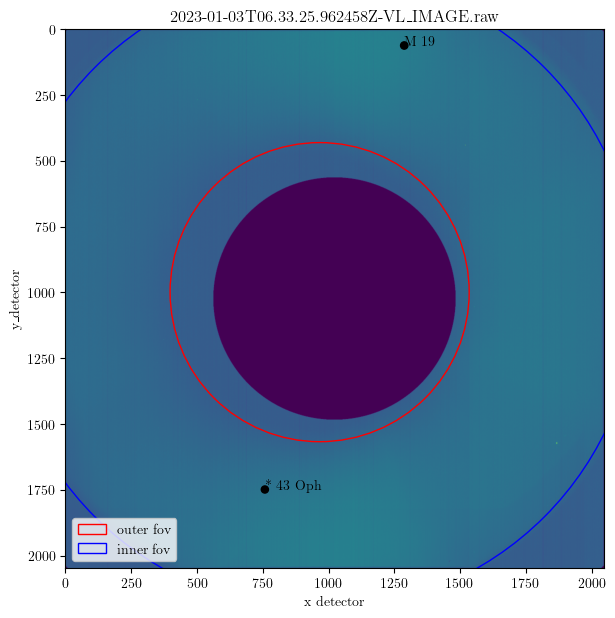

In [24]:
# Retrieve stars.
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, UV, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers)

## 3. Maximum star magnitude.

In order to catch all possible stars, it is important to choose a correct number for the star magnitude threshold. Nevertheless, a higher number could lead to a star misclassification. Then. let's see how this parameter affects the possible number of detected stars.

### 3.1. Visible light

Check possible stars in L0 FITS VL. 

In [11]:
# GLOBAL PARAMETERS
DATASET_DIR_L0 = "/home/stefano98/University of Padua/thesis/dataset/L0"
IMG = "solo_L0_metis-vl-image_0757398438_V01.fits"

# Extract timestamp from FITS file.
L0_vl_path = os.path.join(DATASET_DIR_L0, IMG )
keys = ["FILE_RAW","DATAMIN", "DATAMAX"]
scs, headers, image = fits_loader(L0_vl_path, keys)

**Maximum star magnitude: 6**

(<Axes: title={'center': '2024-01-01T04.59.34.737730Z-VL_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

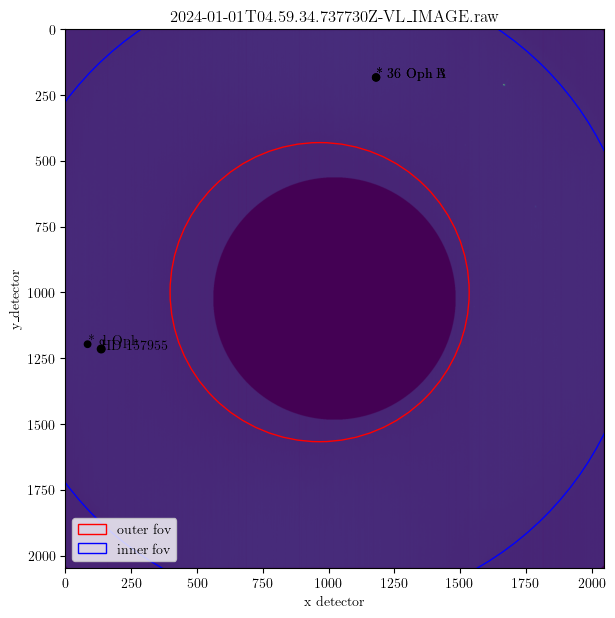

In [12]:
# Retrieve stars.
MAX_MAG = 6
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, UV, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers)

Display obtained stars (PSFs).

In [13]:
def plot_psfs_stars(table, image, lim = 10, uv = False):
    """
    Plot PSFs from possible detected stars.

    Parameters:
        table (df): dataframe with retrieved stars information.
        image (array): base image with stars.
        lim (int): size from center to edge for the star crop region.
        uv (bool): wavelength.
    """

    # Extract number of stars.
    n_stars = len(table)
    n = int(np.ceil(np.sqrt(n_stars)))
    # Handle error for axis flatten.
    if n == 1:
        n = 2
    table = stars_set_off[0]
    table = table.sort_values(by= "mag", ascending = True)

    # Create plot
    fig, axis = plt.subplots(n, n, figsize = (n+2, n +4))
    axis = axis.flatten()
    fig.supxlabel("Detector x")
    fig.supylabel("Detector y")
    
    # Display stars.
    for i in range(n*n):
        if i < len(table):
            x = int(table["xsensor"].iloc[i])
            y = int(table["ysensor"].iloc[i])
            star_name = table["MAIN_ID"].iloc[i]
            mag = table["mag"].iloc[i]
            axis[i].imshow(image[y-lim:y+lim, x-lim:x+lim])
            axis[i].set_title(f"label: {star_name}\nmag: {mag}", fontsize = 8)
            axis[i].set_xticks([]), axis[i].set_yticks([])
        else:
            axis[i].axis("off")
        

    plt.tight_layout()
    

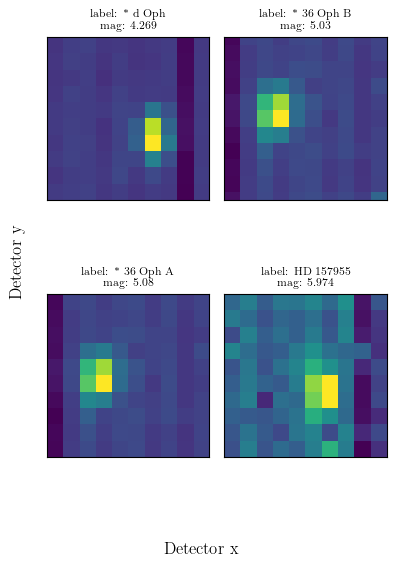

In [14]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 7**

(<Axes: title={'center': '2024-01-01T04.59.34.737730Z-VL_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

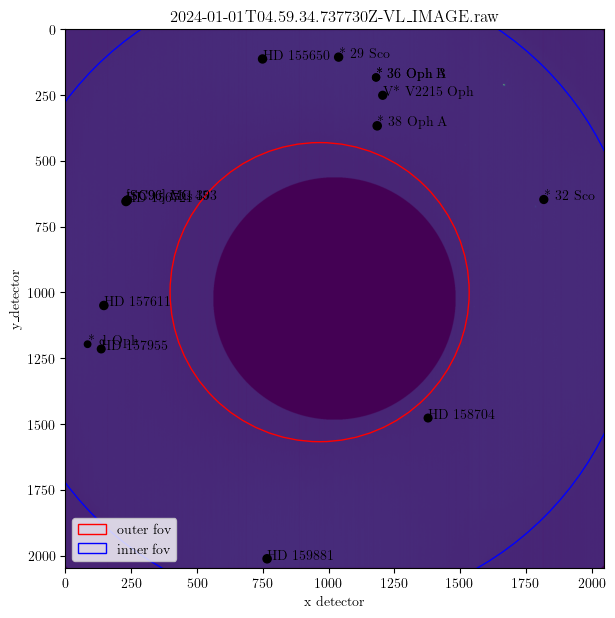

In [15]:
# Retrieve stars.
MAX_MAG = 7
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, UV, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers)

Display obtained stars (PSFs).

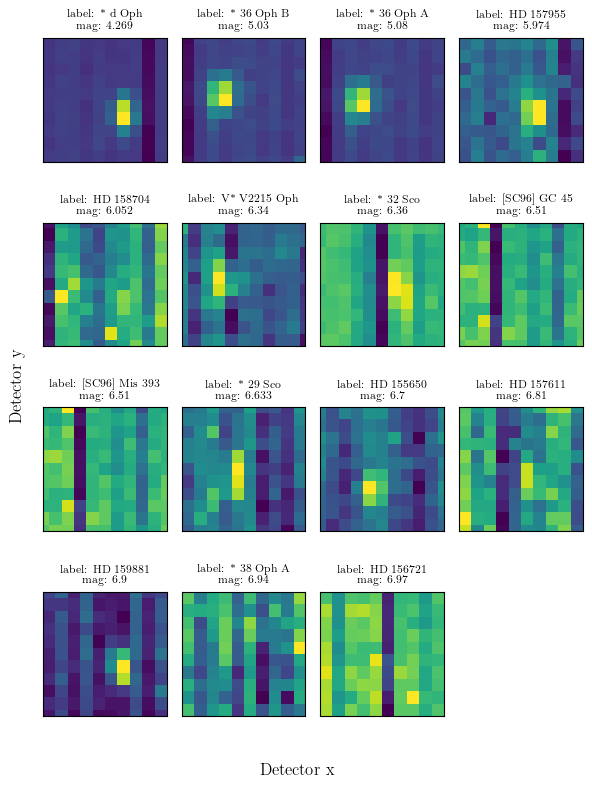

In [16]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 8**

(<Axes: title={'center': '2024-01-01T04.59.34.737730Z-VL_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

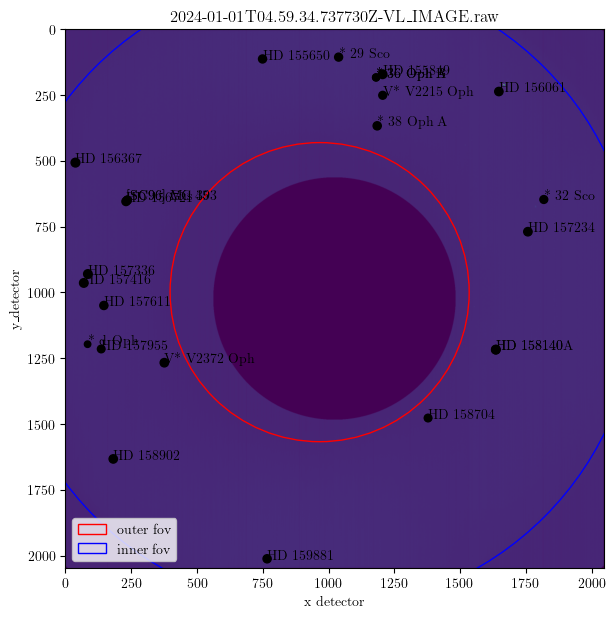

In [17]:
# Retrieve stars.
MAX_MAG = 8
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, UV, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers)

Display obtained stars (PSFs).

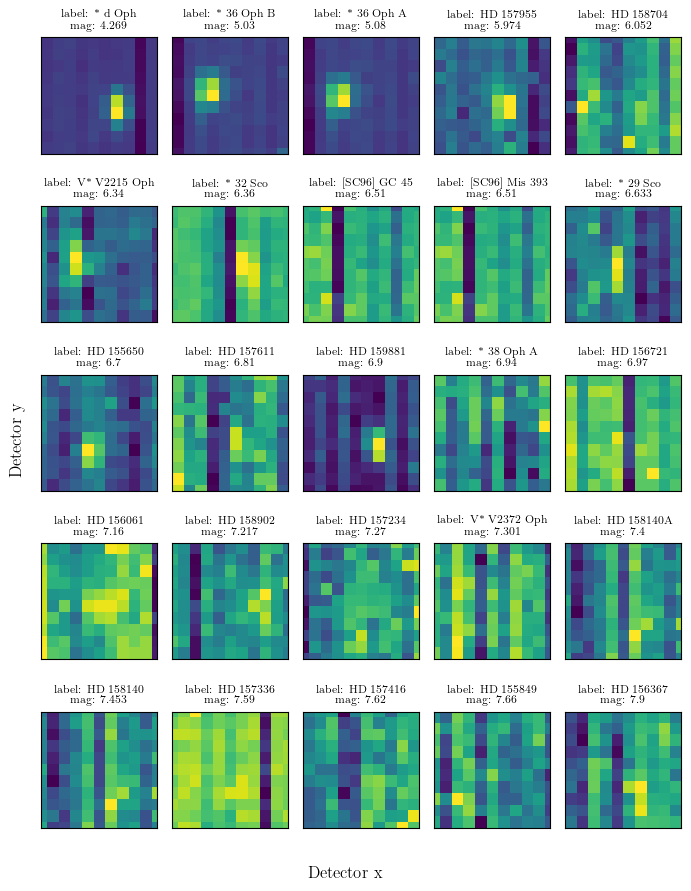

In [18]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 9**

(<Axes: title={'center': '2024-01-01T04.59.34.737730Z-VL_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

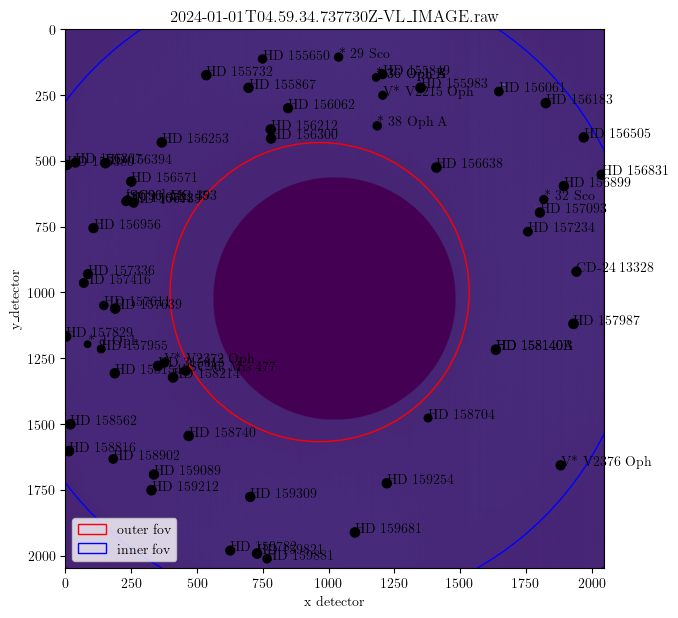

In [19]:
# Retrieve stars.
MAX_MAG = 9
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, UV, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers)

Display obtained stars (PSFs).

/tmp/ipykernel_24057/2665323253.py:34: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axis[i].imshow(image[y-lim:y+lim, x-lim:x+lim])


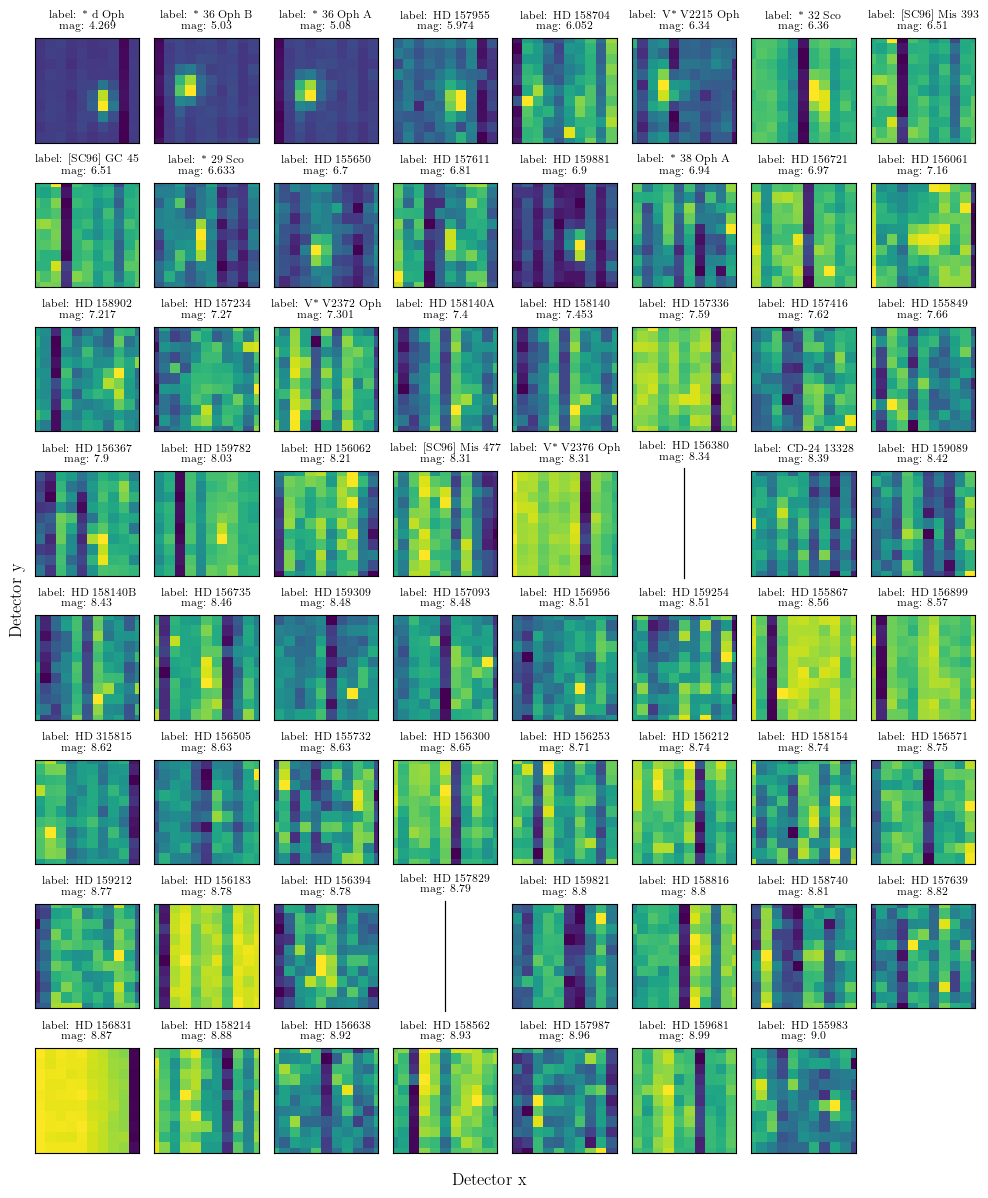

In [20]:
plot_psfs_stars(stars_set_off[0], image)

### 3.2. Ultraviolet light.

In [21]:
# GLOBAL PARAMETERS
DATASET_DIR_L0 = "/home/stefano98/University of Padua/thesis/dataset/L0"
IMG = "solo_L0_metis-uv-image_0767226846_V01.fits"

# Extract timestamp from FITS file.
L0_vl_path = os.path.join(DATASET_DIR_L0, IMG )
keys = ["FILE_RAW","DATAMIN", "DATAMAX"]
scs, headers, image = fits_loader(L0_vl_path, keys)

**Maximum star magnitude: 6**

(<Axes: title={'center': '2024-04-23T22.45.24.755592Z-UV_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

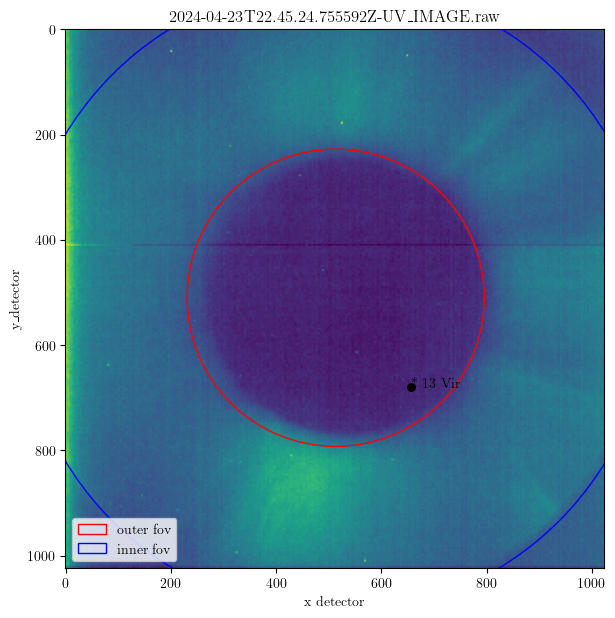

In [22]:
# Retrieve stars.
MAX_MAG = 6
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, True, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers, True)

Display obtained stars (PSFs).

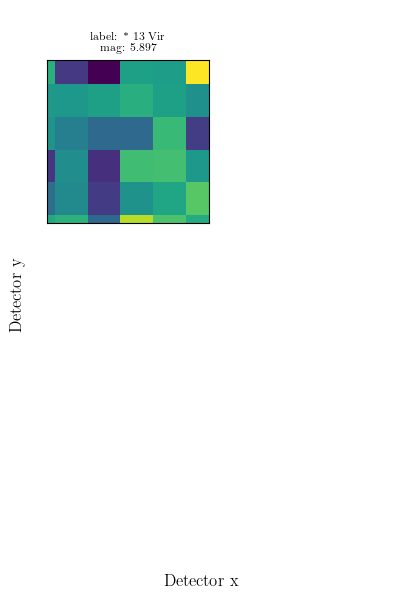

In [23]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 7**

(<Axes: title={'center': '2024-04-23T22.45.24.755592Z-UV_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

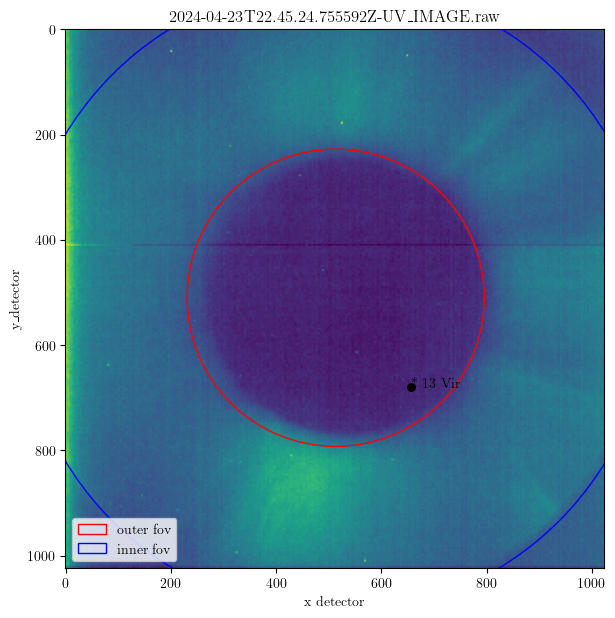

In [24]:
# Retrieve stars.
MAX_MAG = 7
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, True, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers, True)

Display obtained stars (PSFs).

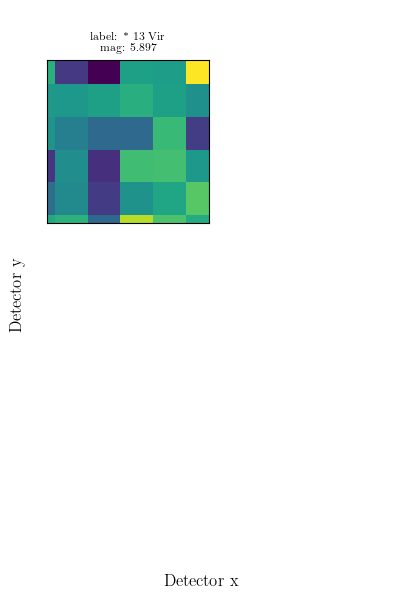

In [25]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 8**

(<Axes: title={'center': '2024-04-23T22.45.24.755592Z-UV_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

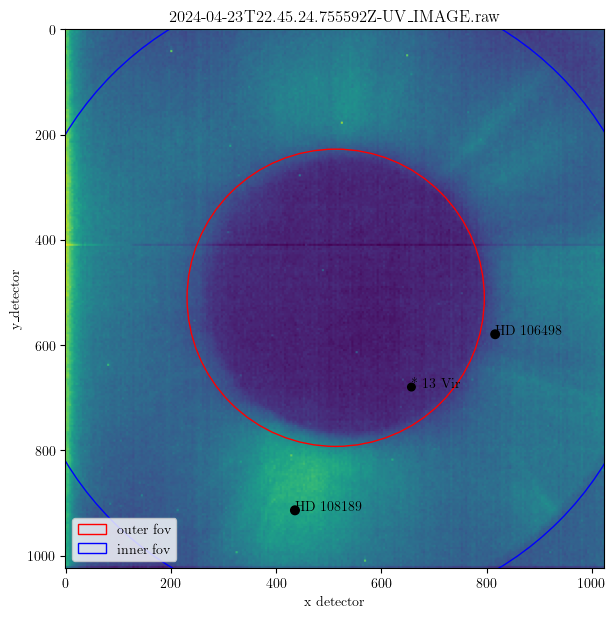

In [26]:
# Retrieve stars.
MAX_MAG = 8
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, True, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers, True)

Display obtained stars (PSFs).

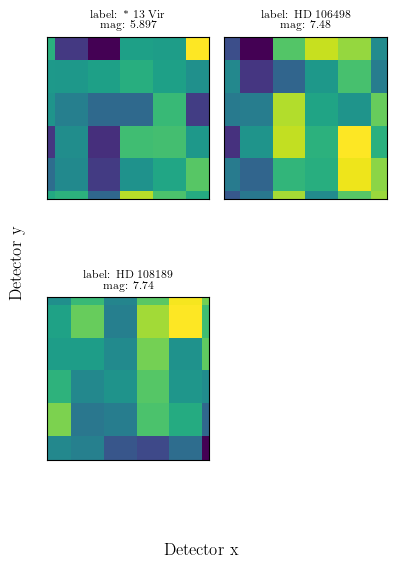

In [27]:
plot_psfs_stars(stars_set_off[0], image)

**Maximum star magnitude: 9**

(<Axes: title={'center': '2024-04-23T22.45.24.755592Z-UV_IMAGE.raw'}, xlabel='x detector', ylabel='y_detector'>,
 <Figure size 700x700 with 1 Axes>)

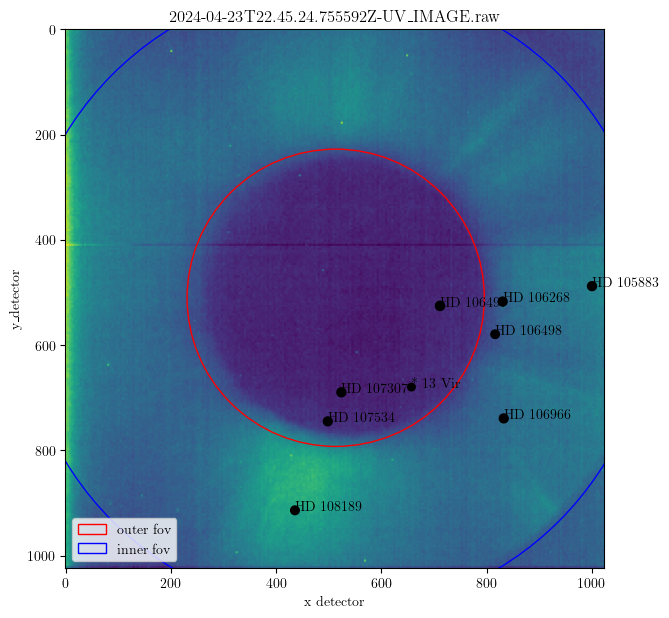

In [28]:
# Retrieve stars.
MAX_MAG = 9
sf.load_kernel(KERNEL_NAME, KERNEL_PATH)
stars_set_off = star_detector_offline(KERNEL_NAME, KERNEL_PATH, scs, True, CAT, MAX_MAG)
sf.unload_kernel(KERNEL_NAME, KERNEL_PATH)

# Plot results.
fits_plotter(stars_set_off[0], stars_set_off[2], stars_set_off[3], image, headers, True)

Display obtained stars (PSFs).

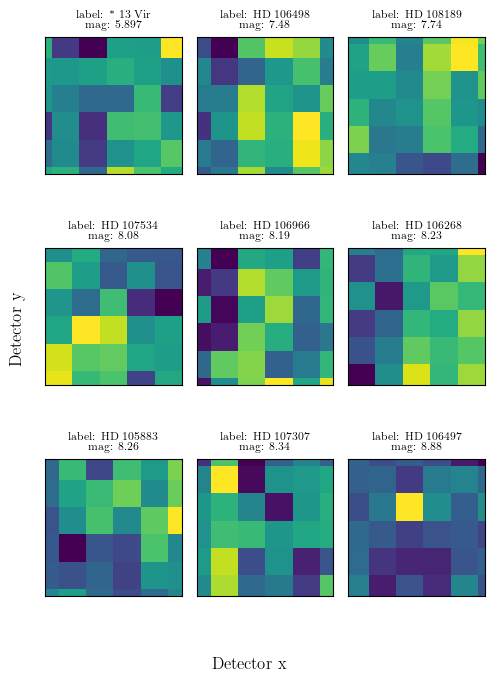

In [29]:
plot_psfs_stars(stars_set_off[0], image)

## 4. Metis trayectory

As an extra, let's construct the path the solar orbiter follows using the computed degrees.

In [30]:
def metis_trayectory(kernel, path, time, interval = 1, limit = 360):
    """
    Extract Metis solar orbiter RA DEC and ROll for simulating its trayectory.

    Paramters:
        kernel (str): SPICE kernel.
        path(str): path to SPICE kernels.
        time (str): time in SCS.
        interval (float): interval (in days) for updating time value 
        limit (int): number of days to simulate.
    Output:
        angles (pandas): dataframe with RA, DEC, ROLL as columns,
    """
    # Create dataframe.
    angles = pd.DataFrame(columns = ["RA", "DEC", "ROLL"])
    # Load kernel.
    spice = sf.load_kernel(kernel, path)
    # Convert starting time to et.
    et = sf.scs2et(time, path)

    for days in range(limit):
        # Calculate boresight orientation.
        ra, dec, roll = sf.boresight(et, path, False)
        angles.loc[(len(angles))] = [ra, dec, roll]
        et = et + interval*24*60
    sf.unload_kernel(kernel, path)
    
    return angles

Text(0.5, 1.0, 'Metis trayectory')

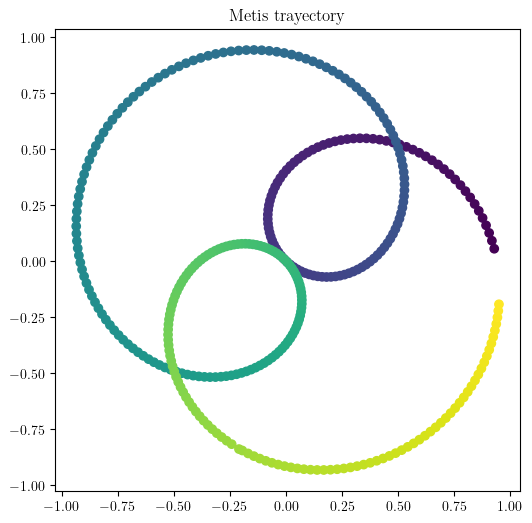

In [31]:
df_angles = metis_trayectory(KERNEL_NAME, KERNEL_PATH, scs)

# Convert in cartesian.
t = np.arange(len(df_angles))
x = np.cos(df_angles["DEC"]) * np.cos(df_angles["RA"])
y = np.cos(df_angles["DEC"]) * np.sin(df_angles["RA"])
z = np.sin(df_angles["DEC"])

colors = np.linspace(0, 1, len(x))

fig, axis = plt.subplots(1, 1, figsize = (6, 6))
axis.scatter(x, y, c=colors,  cmap = "viridis")
axis.set_title("Metis trayectory")